## INF 2178 Diabetes Data Analysis - Haotian Liu

### Environment Setup

*This notebook is running based on the colab environment, make sure to change the data path if you want to run this notebook in your local environment.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q pingouin

### Import Packages

In [3]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import pingouin as pg
import scipy
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import random
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.power import TTestIndPower
import math
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Set random seed
sns.set()
random.seed(5)

### Functions

In [4]:
# Explore attributes with distritbutions and boxplot
# Print out the anova and t-test results
def explore_distribution(feature, cat_var = "Outcome_Cat"):
  
  fig, axes = plt.subplots(1,2, figsize=(20,7))

  axes[0].set_title(f"{feature} Distributions of Outcomes")
  sns.kdeplot(ax = axes[0],data=df, x=feature, hue=cat_var, fill=True)

  axes[1].set_title(f"{feature} Boxplot of Outcomes")
  sns.boxplot(ax = axes[1],data=df, x=cat_var, y=feature) 
  plt.show()
  aov = pg.anova(data=df, dv=feature,between=cat_var,detailed=True)
  print(f"============================== One Way ANOVA of {feature} to {cat_var} ==============================")
  print(aov)
  print()

  # Performing T-Test
  tStat, pValue = stats.ttest_ind(df[df["Outcome"]==0][feature],df[df["Outcome"]==1][feature])
  print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

  # Performing One-Way ANOVA
  alpha = 0.05
  if aov["p-unc"][0] < alpha:
    print(f"The {cat_var} of different {feature} is significant difference")
  else:
    print(f"The {cat_var} of different {feature} is normal, and not significant difference")

### Data Exploration

In [5]:
df = pd.read_csv("/content/drive/MyDrive/INF2178/Midterm/diabetes.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [8]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

#### Data Preprocessing

Check whether there exist missing values

In [9]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
(df==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [11]:
# Replacing 0 with nan
df["Glucose"].replace(0, np.nan, inplace = True)
df["BloodPressure"].replace(0, np.nan, inplace = True)
df["SkinThickness"].replace(0, np.nan, inplace = True)
df["Insulin"].replace(0, np.nan, inplace = True)
df["BMI"].replace(0, np.nan, inplace = True)

In [12]:
df.rename({"DiabetesPedigreeFunction":"FamilyHistory"}, axis = 1, inplace = True)

In [13]:
(df==0).sum()

Pregnancies      111
Glucose            0
BloodPressure      0
SkinThickness      0
Insulin            0
BMI                0
FamilyHistory      0
Age                0
Outcome          500
dtype: int64

In [14]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [15]:
# Map 1 to True and 0 to False
df["Outcome_Cat"] = df["Outcome"].map({1:"True", 0:"False"})
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0      NaN  33.6   
1            1     85.0           66.0           29.0      NaN  26.6   
2            8    183.0           64.0            NaN      NaN  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   FamilyHistory  Age  Outcome Outcome_Cat  
0          0.627   50        1        True  
1          0.351   31        0       False  
2          0.672   32        1        True  
3          0.167   21        0       False  
4          2.288   33        1        True

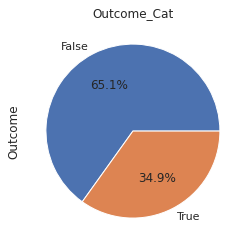

In [16]:
df.groupby("Outcome_Cat").Outcome.count().plot.pie(autopct = "%.1f%%")
plt.title("Outcome_Cat")
plt.show()

In [17]:
size = TTestIndPower().solve_power(effect_size=0.8, alpha=0.05, power= 0.8)
print('Minimum Sample Size: ', size)

Minimum Sample Size:  25.52457250047935


In [18]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  763.000000     733.000000     541.000000  394.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.535641      12.382158      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  141.000000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  FamilyHistory         Age     Outcome  
count  757.000000     768.000000  768.000000  768.000000  
mean    32.457464       0.471876   33.240885    0.348958  
std      6.924988       0.331329   11.760232    0.476951  
min     18.200000       0.078000   21.000000    0.000000  
25%     27.500000       0.243750   24.000000    0.000000  
50%     32.300000       0.372500   29.000000    0.000000  
75%     36.600000       0.626250   41.000000    1.000000  
max     67.100000       2.420000   81.000000    1.000000

In [19]:
# Replacing nan value to median
choice = 1
if choice == 0:
  df.dropna(axis=0, inplace = True)
  df.reset_index(drop=True, inplace = True)
elif choice == 1:
  df.fillna(df.median(),inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


In [20]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   FamilyHistory  Age  Outcome Outcome_Cat  
0          0.627   50        1        True  
1          0.351   31        0       False  
2          0.672   32        1        True  
3          0.167   21        0       False  
4          2.288   33        1        True

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    float64
 2   BloodPressure  768 non-null    float64
 3   SkinThickness  768 non-null    float64
 4   Insulin        768 non-null    float64
 5   BMI            768 non-null    float64
 6   FamilyHistory  768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
 9   Outcome_Cat    768 non-null    object 
dtypes: float64(6), int64(3), object(1)
memory usage: 60.1+ KB


In [22]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   FamilyHistory  Age  Outcome Outcome_Cat  
0          0.627   50        1        True  
1          0.351   31        0       False  
2          0.672   32        1        True  
3          0.167   21        0       False  
4          2.288   33        1        True

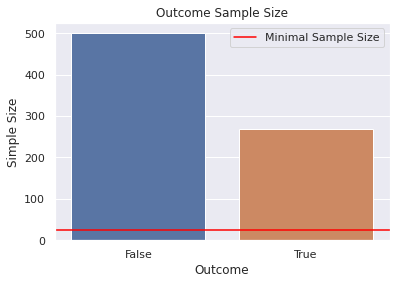

In [23]:
ax = sns.barplot( x = ["False","True"], y =df["Outcome_Cat"].value_counts().to_list())
ax.axhline(26, color="red",label = "Minimal Sample Size")
plt.xlabel("Outcome")
plt.ylabel("Simple Size")
plt.title("Outcome Sample Size")

plt.legend()
plt.show()

In [24]:
# https://www.cdc.gov/obesity/adult/defining.html
df["BMI_Cat"]=pd.cut(df["BMI"],[df["BMI"].min()-1,18.5,25,30,df["BMI"].max()+1],labels=["Underweight","Health weight", "Overweight","Obesity"])

In [25]:
# https://www.nia.nih.gov/health/high-blood-pressure-and-older-adults
df["Bloodpressure_Cat"]=pd.cut(df["BloodPressure"],[df["BloodPressure"].min()-1,60,80,df["BloodPressure"].max()+1],labels=["Low","Normal", "High"])

In [26]:
# https://www.statcan.gc.ca/en/concepts/definitions/age2
df["Age_Cat"]=pd.cut(df["Age"],[df["Age"].min()-1,25,65,df["Age"].max()+1],labels=["Youth","Adult", "Senior"])

In [27]:
df.head(100)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             6    148.0           72.0           35.0    125.0  33.6   
1             1     85.0           66.0           29.0    125.0  26.6   
2             8    183.0           64.0           29.0    125.0  23.3   
3             1     89.0           66.0           23.0     94.0  28.1   
4             0    137.0           40.0           35.0    168.0  43.1   
..          ...      ...            ...            ...      ...   ...   
95            6    144.0           72.0           27.0    228.0  33.9   
96            2     92.0           62.0           28.0    125.0  31.6   
97            1     71.0           48.0           18.0     76.0  20.4   
98            6     93.0           50.0           30.0     64.0  28.7   
99            1    122.0           90.0           51.0    220.0  49.7   

    FamilyHistory  Age  Outcome Outcome_Cat        BMI_Cat Bloodpressure_Cat  \
0           0.627   50        1        True        Obesity            Normal   
1           0.351   31        0       False     Overweight            Normal   
2           0.672   32        1        True  Health weight            Normal   
3           0.167   21        0       False     Overweight            Normal   
4           2.288   33        1        True        Obesity               Low   
..            ...  ...      ...         ...            ...               ...   
95          0.255   40        0       False        Obesity            Normal   
96          0.130   24        0       False        Obesity            Normal   
97          0.323   22        0       False  Health weight               Low   
98          0.356   23        0       False     Overweight               Low   
99          0.325   31        1        True        Obesity              High   

   Age_Cat  
0    Adult  
1    Adult  
2    Adult  
3    Youth  
4    Adult  
..     ...  
95   Adult  
96   Youth  
97   Youth  
98   Youth  
99   Adult  

[100 rows x 13 columns]

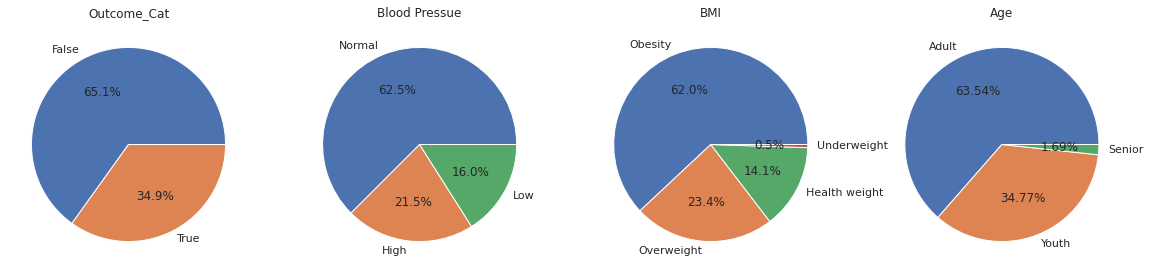

In [28]:
fig, axes = plt.subplots(1,4, figsize=(20,5))


axes[0].pie(df["Outcome_Cat"].value_counts(), autopct='%.1f%%', labels = ["False", "True"])
axes[0].set_title("Outcome_Cat")

axes[1].pie(df["Bloodpressure_Cat"].value_counts(), autopct='%.1f%%', labels  = ["Normal", "High", "Low"])
axes[1].set_title("Blood Pressue")

axes[2].pie(df["BMI_Cat"].value_counts(), autopct='%.1f%%', labels = [ "Obesity","Overweight","Health weight","Underweight"])
axes[2].set_title("BMI")

axes[3].pie(df["Age_Cat"].value_counts(), autopct='%.2f%%', labels = ["Adult", "Youth", "Senior"])
axes[3].set_title("Age")
plt.show()

In [29]:
# Print value names
cat_features = df.select_dtypes(include=["object", "category"]).columns
num_features = df.select_dtypes(exclude=["object", "category"]).columns
print("Catergorical Features: ")
print(" | ".join(cat_features))
print("Numbers of categorical features: ", len(cat_features))
print()
print("Numerical Features: ")
print(" | ".join(num_features))
print("Numbers of numerical features: ", len(num_features))

Catergorical Features: 
Outcome_Cat | BMI_Cat | Bloodpressure_Cat | Age_Cat
Numbers of categorical features:  4

Numerical Features: 
Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI | FamilyHistory | Age | Outcome
Numbers of numerical features:  9


In [30]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  FamilyHistory         Age     Outcome  
count  768.000000     768.000000  768.000000  768.000000  
mean    32.455208       0.471876   33.240885    0.348958  
std      6.875177       0.331329   11.760232    0.476951  
min     18.200000       0.078000   21.000000    0.000000  
25%     27.500000       0.243750   24.000000    0.000000  
50%     32.300000       0.372500   29.000000    0.000000  
75%     36.600000       0.626250   41.000000    1.000000  
max     67.100000       2.420000   81.000000    1.000000

#### Diabetes Outcomes

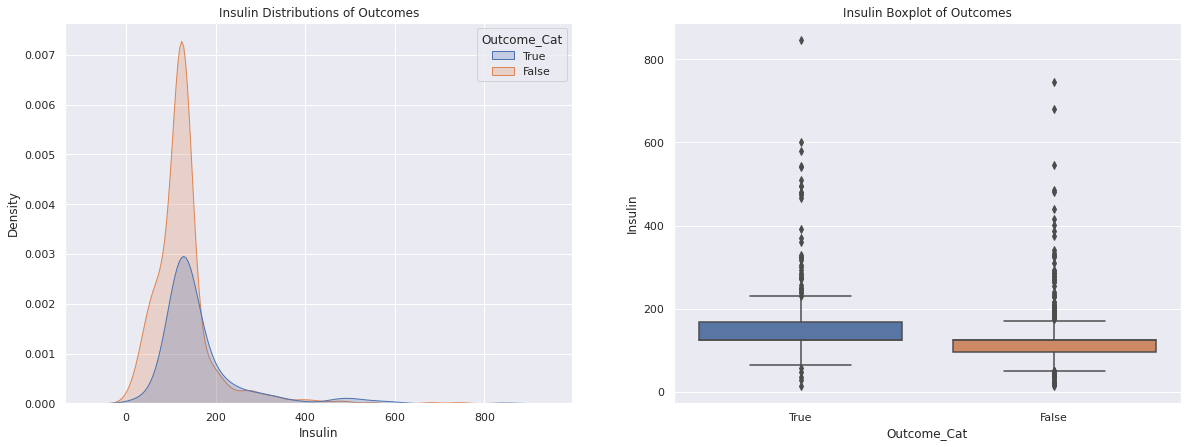

============================== One Way ANOVA of Insulin to Outcome_Cat ==============================
        Source            SS   DF             MS          F         p-unc  \
0  Outcome_Cat  2.376948e+05    1  237694.825097  33.190796  1.210026e-08   
1       Within  5.485684e+06  766    7161.467999        NaN           NaN   

        np2  
0  0.041531  
1       NaN  

P-Value:1.210025703412445e-08 T-Statistic:-5.76114539252401
The Outcome_Cat of different Insulin is significant difference


In [31]:
explore_distribution("Insulin")

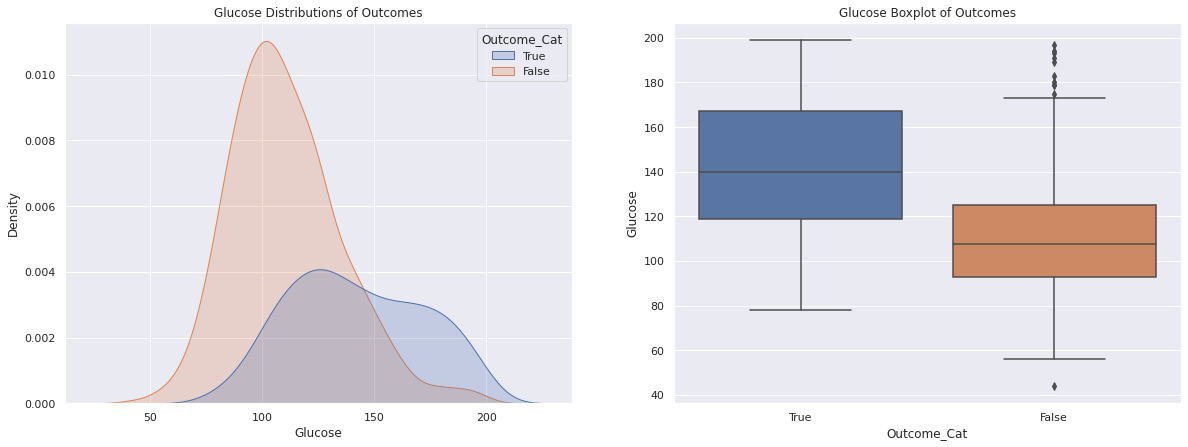

============================== One Way ANOVA of Glucose to Outcome_Cat ==============================
        Source             SS   DF             MS           F         p-unc  \
0  Outcome_Cat  172562.382896    1  172562.382896  245.667855  3.128719e-48   
1       Within  538054.867104  766     702.421498         NaN           NaN   

        np2  
0  0.242834  
1       NaN  

P-Value:3.1287190418423694e-48 T-Statistic:-15.673795182294105
The Outcome_Cat of different Glucose is significant difference


In [32]:
explore_distribution("Glucose")

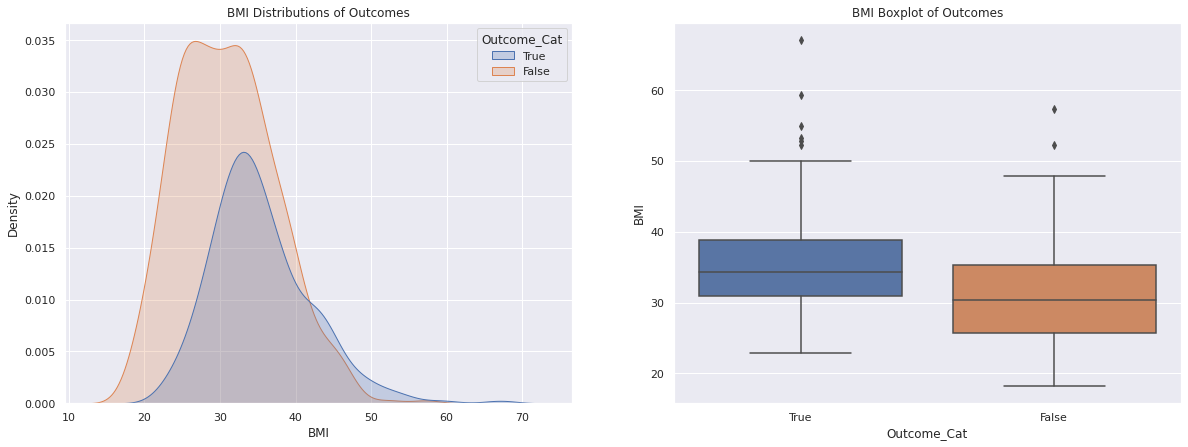

============================== One Way ANOVA of BMI to Outcome_Cat ==============================
        Source            SS   DF           MS          F         p-unc  \
0  Outcome_Cat   3530.035085    1  3530.035085  82.629271  8.336903e-19   
1       Within  32724.564081  766    42.721363        NaN           NaN   

        np2  
0  0.097368  
1       NaN  

P-Value:8.336902677509037e-19 T-Statistic:-9.090064413986648
The Outcome_Cat of different BMI is significant difference


In [33]:
explore_distribution("BMI")

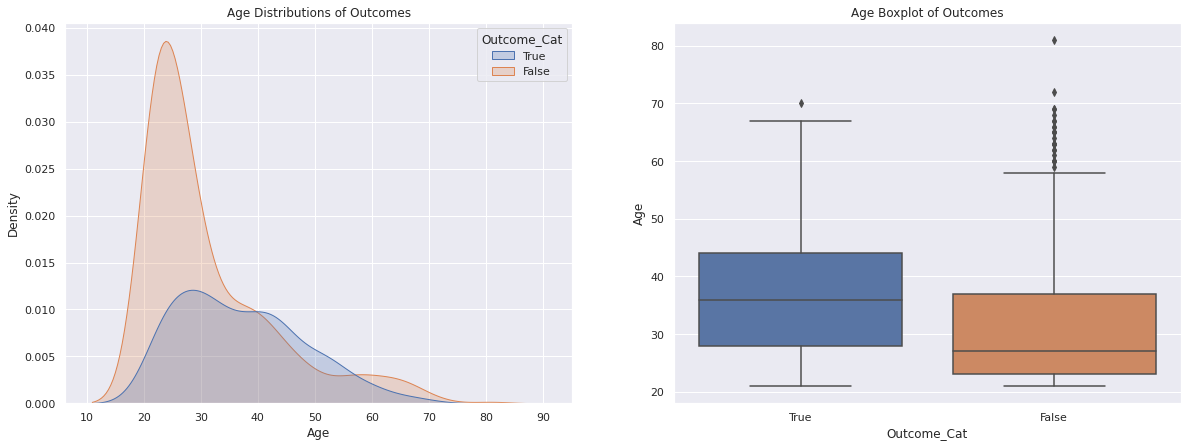

============================== One Way ANOVA of Age to Outcome_Cat ==============================
        Source             SS   DF           MS          F         p-unc  \
0  Outcome_Cat    6026.695153    1  6026.695153  46.140611  2.209975e-11   
1       Within  100051.741045  766   130.615850        NaN           NaN   

        np2  
0  0.056814  
1       NaN  

P-Value:2.2099754606654358e-11 T-Statistic:-6.792688071649956
The Outcome_Cat of different Age is significant difference


In [34]:
explore_distribution("Age")

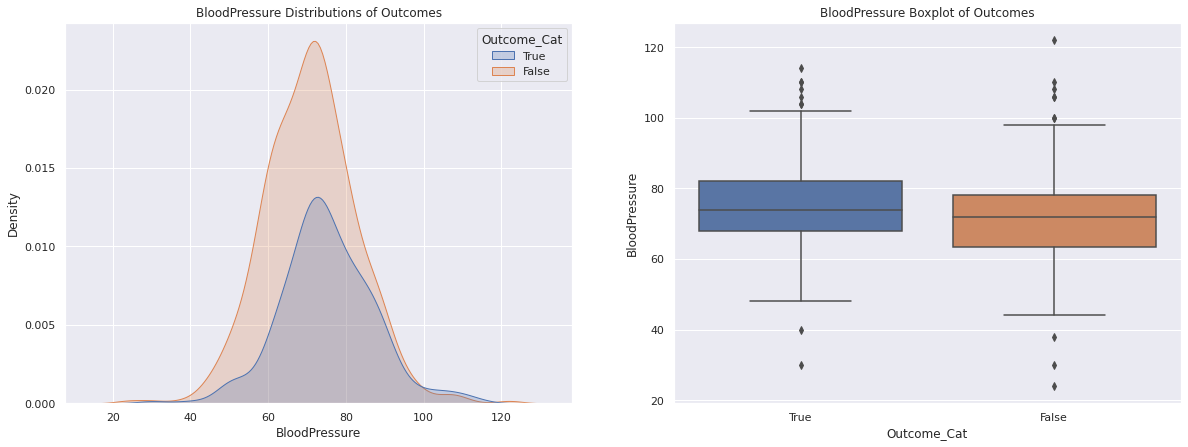

============================== One Way ANOVA of BloodPressure to Outcome_Cat ==============================
        Source             SS   DF           MS         F     p-unc       np2
0  Outcome_Cat    3082.407964    1  3082.407964  21.63158  0.000004  0.027464
1       Within  109151.736567  766   142.495740       NaN       NaN       NaN

P-Value:3.8908354906479115e-06 T-Statistic:-4.65097622072597
The Outcome_Cat of different BloodPressure is significant difference


In [35]:
explore_distribution("BloodPressure")

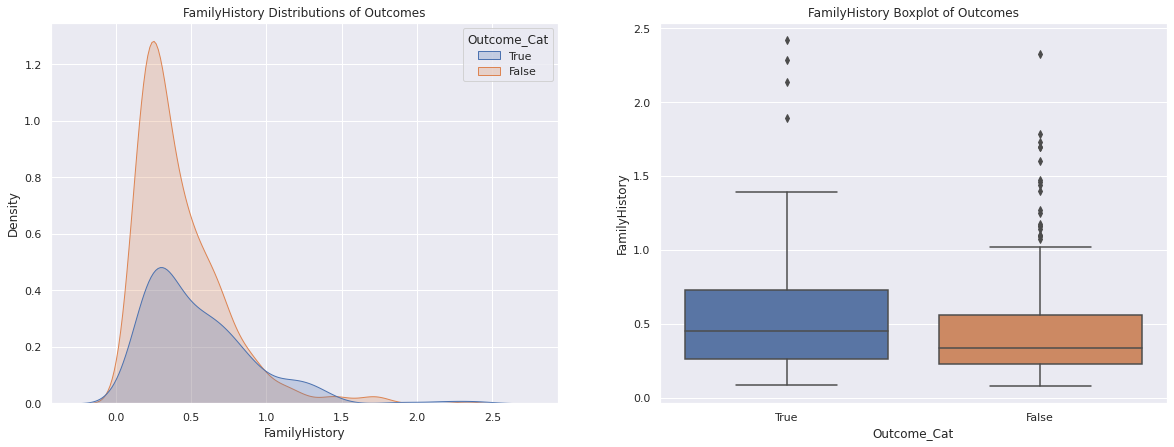

============================== One Way ANOVA of FamilyHistory to Outcome_Cat ==============================
        Source         SS   DF        MS        F     p-unc       np2
0  Outcome_Cat   2.544679    1  2.544679  23.8713  0.000001  0.030222
1       Within  81.655537  766  0.106600      NaN       NaN       NaN

P-Value:1.254607010148809e-06 T-Statistic:-4.88582646072744
The Outcome_Cat of different FamilyHistory is significant difference


In [36]:
explore_distribution("FamilyHistory")

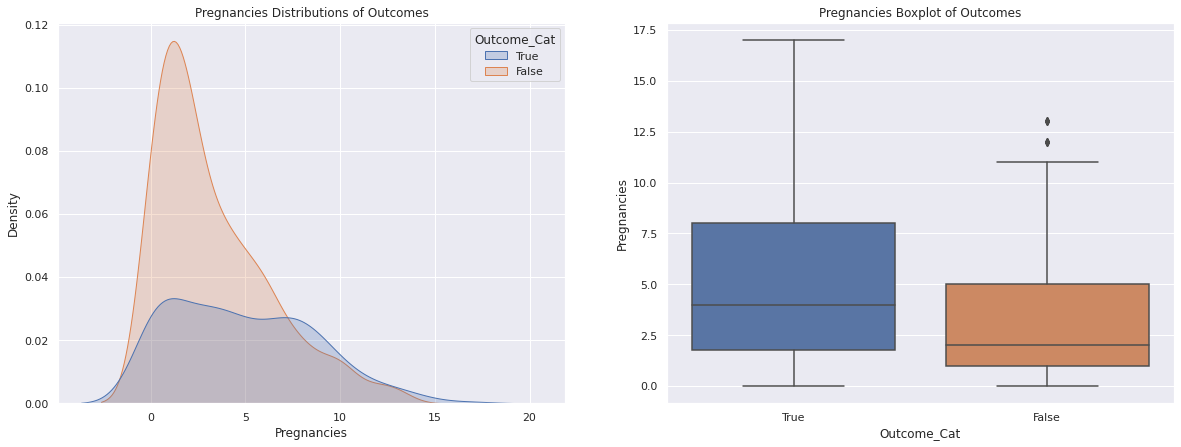

============================== One Way ANOVA of Pregnancies to Outcome_Cat ==============================
        Source           SS   DF          MS          F         p-unc  \
0  Outcome_Cat   428.799019    1  428.799019  39.670227  5.065127e-10   
1       Within  8279.762179  766   10.809089        NaN           NaN   

        np2  
0  0.049239  
1       NaN  

P-Value:5.065127298053476e-10 T-Statistic:-6.298430550035151
The Outcome_Cat of different Pregnancies is significant difference


In [37]:
explore_distribution("Pregnancies")

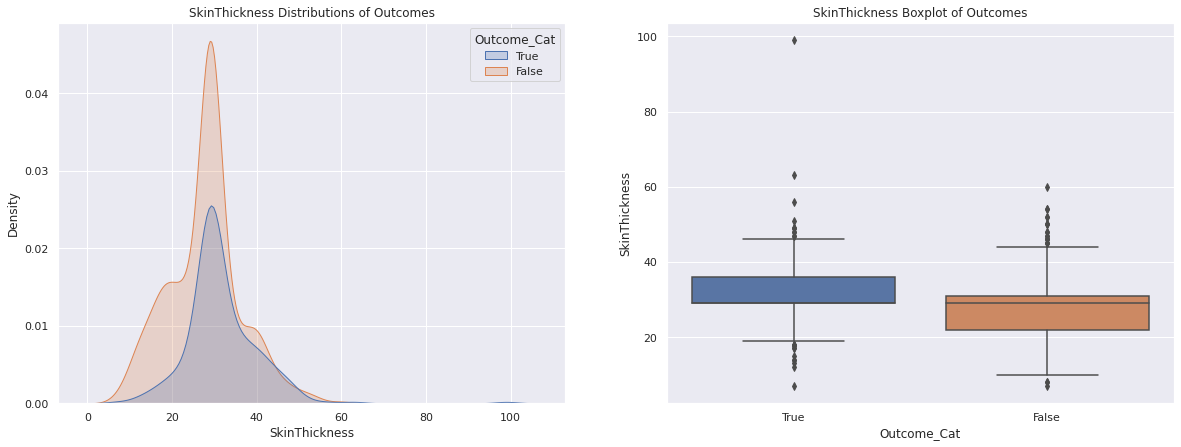

============================== One Way ANOVA of SkinThickness to Outcome_Cat ==============================
        Source            SS   DF           MS          F         p-unc  \
0  Outcome_Cat   2736.896306    1  2736.896306  37.078538  1.793958e-09   
1       Within  56541.133642  766    73.813490        NaN           NaN   

        np2  
0  0.046171  
1       NaN  

P-Value:1.7939583262325828e-09 T-Statistic:-6.089214889295934
The Outcome_Cat of different SkinThickness is significant difference


In [38]:
explore_distribution("SkinThickness")

#### Insulin 

In [39]:
# Performing pairwise tukey test
pt = pg.pairwise_tukey(dv='Insulin',between='Age_Cat',effsize='cohen',data=df)
print(pt)

       A       B     mean(A)     mean(B)       diff         se         T  \
0  Youth   Adult  131.142322  146.436475 -15.294153   6.557684 -2.332249   
1  Youth  Senior  131.142322  120.000000  11.142322  24.467761  0.455388   
2  Adult  Senior  146.436475  120.000000  26.436475  24.209164  1.092003   

    p-tukey     cohen  
0  0.052051 -0.177535  
1  0.892020  0.129340  
2  0.519313  0.306875  


In [40]:
pt = pg.pairwise_tukey(dv='Insulin',between='BMI_Cat',effsize='cohen',data=df)
print(pt)

               A              B     mean(A)     mean(B)       diff         se  \
0    Underweight  Health weight  114.250000  115.583333  -1.333333  43.290268   
1    Underweight     Overweight  114.250000  123.155556  -8.905556  42.979939   
2    Underweight        Obesity  114.250000  153.210084 -38.960084  42.688440   
3  Health weight     Overweight  115.583333  123.155556  -7.572222  10.348353   
4  Health weight        Obesity  115.583333  153.210084 -37.626751   9.061794   
5     Overweight        Obesity  123.155556  153.210084 -30.054528   7.439356   

          T   p-tukey     cohen  
0 -0.030800  0.999989 -0.015683  
1 -0.207203  0.996853 -0.104746  
2 -0.912661  0.798108 -0.458244  
3 -0.731732  0.884345 -0.089064  
4 -4.152241  0.000214 -0.442561  
5 -4.039937  0.000342 -0.353498  


In [41]:
# Performing Two-ANOVA 
model = ols('Insulin ~  C(Age_Cat)+C(BMI_Cat) + C(Age_Cat):C(BMI_Cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

sum_sq     df         F    PR(>F)
Intercept              2.142450e+04    1.0  2.953912  0.086079
C(Age_Cat)             6.278273e+02    2.0  0.043281  0.957645
C(BMI_Cat)             6.697432e+04    3.0  3.078038  0.026938
C(Age_Cat):C(BMI_Cat)  8.548098e+03    6.0  0.196429  0.977824
Residual               5.490463e+06  757.0       NaN       NaN

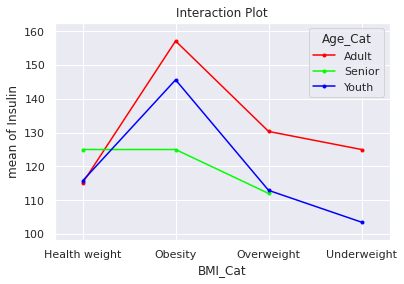

In [42]:
# Interaction plot
interaction_plot(x=df['BMI_Cat'].astype("str"), trace=df['Age_Cat'].astype("str"), response=df['Insulin'])
plt.title("Interaction Plot")
plt.show()

In [43]:
pt = pg.pairwise_tukey(dv='Insulin',between='Bloodpressure_Cat',effsize='cohen',data=df)
print(pt)

        A       B     mean(A)     mean(B)       diff         se         T  \
0     Low  Normal  138.878049  136.258333   2.619715   8.708573  0.300820   
1     Low    High  138.878049  154.848485 -15.970436  10.265101 -1.555799   
2  Normal    High  136.258333  154.848485 -18.590152   7.776403 -2.390585   

    p-tukey     cohen  
0  0.951345  0.030401  
1  0.265647 -0.185334  
2  0.044910 -0.215735  


In [44]:
model = ols('Insulin ~  C(Bloodpressure_Cat)+C(Outcome_Cat) + C(Bloodpressure_Cat):C(Outcome_Cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

sum_sq     df           F  \
Intercept                            1.418719e+06    1.0  202.000529   
C(Bloodpressure_Cat)                 3.943505e+04    2.0    2.807427   
C(Outcome_Cat)                       2.089801e+05    1.0   29.755068   
C(Bloodpressure_Cat):C(Outcome_Cat)  1.062130e+05    2.0    7.561426   
Residual                             5.351788e+06  762.0         NaN   

                                           PR(>F)  
Intercept                            7.752955e-41  
C(Bloodpressure_Cat)                 6.098459e-02  
C(Outcome_Cat)                       6.630711e-08  
C(Bloodpressure_Cat):C(Outcome_Cat)  5.601136e-04  
Residual                                      NaN

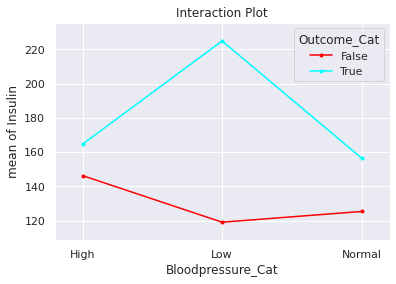

In [45]:
interaction_plot(x=df['Bloodpressure_Cat'].astype("str"), trace=df['Outcome_Cat'].astype("str"), response=df['Insulin'])
plt.title("Interaction Plot")
plt.show()

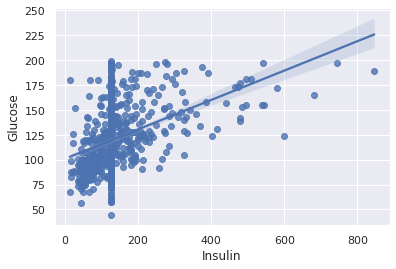

In [46]:
sns.regplot(x="Insulin", y="Glucose", data = df)

#### Glucose

Text(0.5, 1.0, 'Correlation Table')

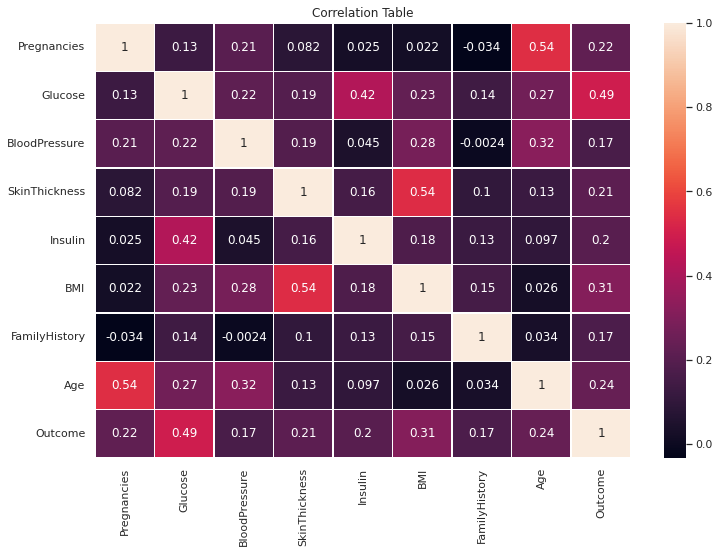

In [47]:
# Print correlation
plt.figure(figsize=(12,8)) 
corr = df[num_features].corr()
sns.heatmap(corr,annot=True, annot_kws={"size":12}, linewidth = 0.5)
plt.title("Correlation Table")

Text(0.5, 1.0, 'Regression Plot')

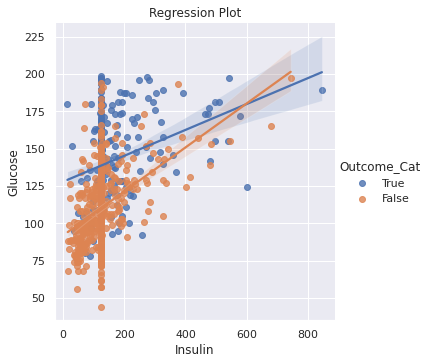

In [48]:
sns.lmplot(x="Insulin", y="Glucose", hue="Outcome_Cat", data=df)
plt.title("Regression Plot")

In [49]:
pt = pg.pairwise_tukey(dv='Glucose',between='BMI_Cat',effsize='cohen',data=df)
print(pt)

               A              B     mean(A)     mean(B)       diff         se  \
0    Underweight  Health weight   95.250000  108.175926 -12.925926  15.139833   
1    Underweight     Overweight   95.250000  118.005556 -22.755556  15.031302   
2    Underweight        Obesity   95.250000  126.317227 -31.067227  14.929357   
3  Health weight     Overweight  108.175926  118.005556  -9.829630   3.619112   
4  Health weight        Obesity  108.175926  126.317227 -18.141301   3.169166   
5     Overweight        Obesity  118.005556  126.317227  -8.311671   2.601753   

          T       p-tukey     cohen  
0 -0.853769  8.285515e-01 -0.434718  
1 -1.513878  4.296106e-01 -0.765303  
2 -2.080949  1.602389e-01 -1.044837  
3 -2.716033  3.407232e-02 -0.330585  
4 -5.724314  8.935604e-08 -0.610119  
5 -3.194642  7.932506e-03 -0.279534  


In [50]:
pt = pg.pairwise_tukey(dv='Glucose',between='Bloodpressure_Cat',effsize='cohen',data=df)
print(pt)

        A       B     mean(A)     mean(B)       diff        se         T  \
0     Low  Normal  111.617886  120.477083  -8.859197  3.008421 -2.944800   
1     Low    High  111.617886  132.569697 -20.951811  3.546132 -5.908357   
2  Normal    High  120.477083  132.569697 -12.092614  2.686398 -4.501422   

        p-tukey     cohen  
0  9.323603e-03 -0.297606  
1  1.558701e-08 -0.703831  
2  2.322071e-05 -0.406225  


In [51]:
pt = pg.pairwise_tukey(dv='Glucose',between='Age_Cat',effsize='cohen',data=df)
print(pt)

       A       B     mean(A)     mean(B)       diff        se         T  \
0  Youth   Adult  112.033708  126.510246 -14.476538  2.254952 -6.419887   
1  Youth  Senior  112.033708  137.076923 -25.043215  8.413586 -2.976521   
2  Adult  Senior  126.510246  137.076923 -10.566677  8.324663 -1.269322   

        p-tukey     cohen  
0  7.172982e-10 -0.488692  
1  8.443228e-03 -0.845397  
2  4.130024e-01 -0.356705  


In [52]:
model = ols('Glucose ~ C(Bloodpressure_Cat)+C(Outcome_Cat) + C(Bloodpressure_Cat):C(Outcome_Cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

sum_sq     df            F  \
Intercept                            1.105021e+06    1.0  1612.909270   
C(Bloodpressure_Cat)                 1.537114e+04    2.0    11.217997   
C(Outcome_Cat)                       2.257987e+04    1.0    32.957989   
C(Bloodpressure_Cat):C(Outcome_Cat)  3.371542e+03    2.0     2.460582   
Residual                             5.220544e+05  762.0          NaN   

                                            PR(>F)  
Intercept                            2.804781e-190  
C(Bloodpressure_Cat)                  1.579180e-05  
C(Outcome_Cat)                        1.359723e-08  
C(Bloodpressure_Cat):C(Outcome_Cat)   8.606344e-02  
Residual                                       NaN

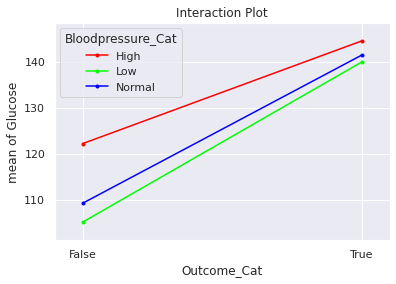

In [53]:
interaction_plot(x=df['Outcome_Cat'].astype("str"), trace=df['Bloodpressure_Cat'].astype("str"), response=df['Glucose'])
plt.title("Interaction Plot")
plt.show()

In [54]:
model = ols('Glucose ~ C(Age_Cat)+C(BMI_Cat) + C(Age_Cat):C(BMI_Cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

sum_sq     df          F    PR(>F)
Intercept               18818.000000    1.0  22.305855  0.000003
C(Age_Cat)               2948.225045    2.0   1.747334  0.174940
C(BMI_Cat)               9193.515702    3.0   3.632501  0.012699
C(Age_Cat):C(BMI_Cat)   13118.390099    6.0   2.591640  0.017145
Residual               638631.707838  757.0        NaN       NaN

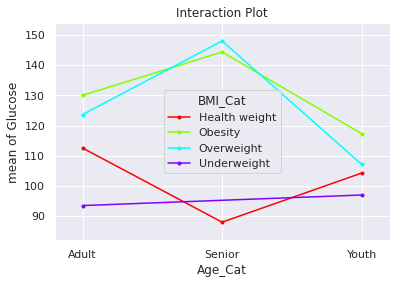

In [55]:
interaction_plot(x=df['Age_Cat'].astype("str"), trace=df['BMI_Cat'].astype("str"), response=df['Glucose'])
plt.title("Interaction Plot")
plt.show()

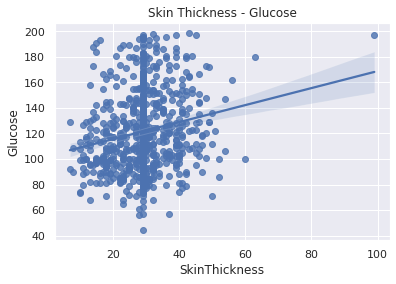

In [56]:
sns.regplot(x="SkinThickness", y="Glucose", data =df)
plt.title("Skin Thickness - Glucose")
plt.show()

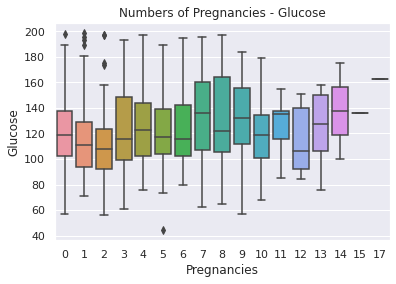

In [57]:
sns.boxplot(x="Pregnancies", y="Glucose", data =df)
plt.title("Numbers of Pregnancies - Glucose")
plt.show()

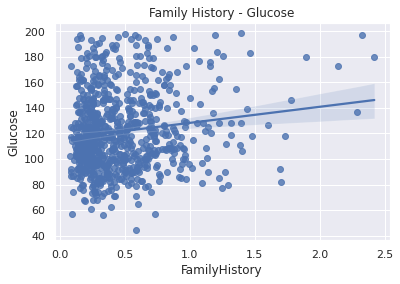

In [58]:
sns.regplot(x="FamilyHistory", y="Glucose", data =df)
plt.title("Family History - Glucose")
plt.show()

#### BMI, Skin Thickness, Blood Pressure

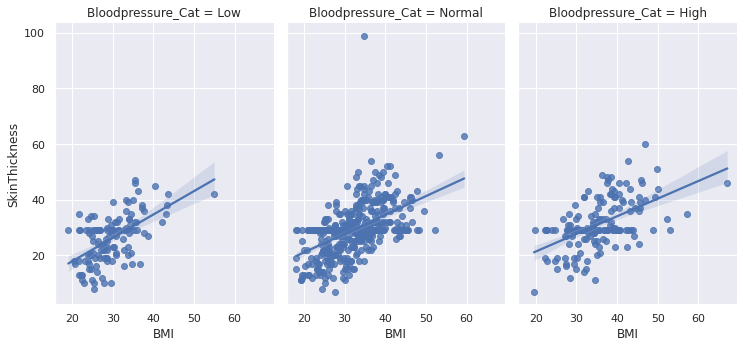

In [59]:
g = sns.FacetGrid(df, col="Bloodpressure_Cat",height=5, aspect = .7)
g.map_dataframe(sns.regplot, x="BMI", y="SkinThickness")

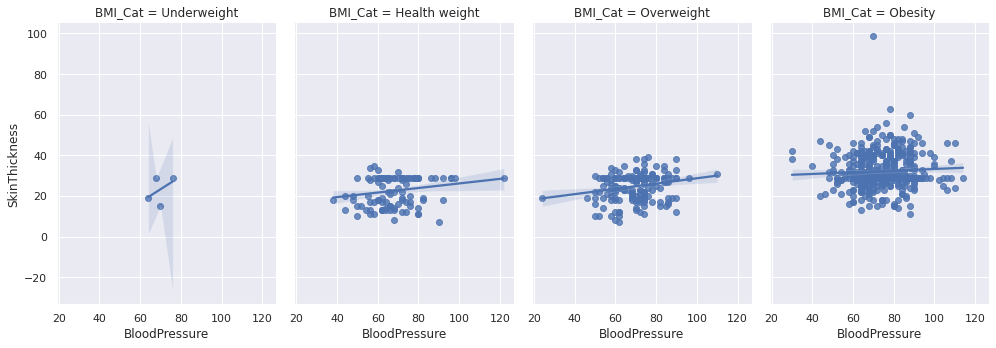

In [60]:
g = sns.FacetGrid(df, col="BMI_Cat",height=5, aspect = .7)
g.map_dataframe(sns.regplot, x="BloodPressure", y="SkinThickness")

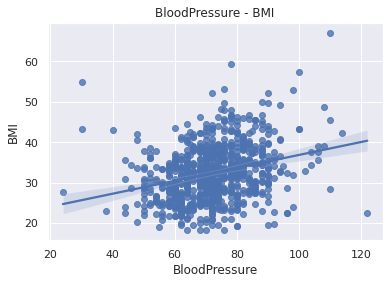

In [61]:
sns.regplot(data =df, x="BloodPressure", y="BMI") 
plt.title("BloodPressure - BMI")
plt.show()

In [62]:
pt = pg.pairwise_tukey(dv='BMI',between='Age_Cat',effsize='cohen',data=df)
print(pt)

       A       B    mean(A)    mean(B)      diff        se         T  \
0  Youth   Adult  31.205618  33.223770 -2.018153  0.517948 -3.896440   
1  Youth  Senior  31.205618  29.269231  1.936387  1.932546  1.001988   
2  Adult  Senior  33.223770  29.269231  3.954540  1.912121  2.068143   

    p-tukey     cohen  
0  0.000312 -0.296603  
1  0.575818  0.284586  
2  0.097203  0.581190  


In [63]:
pt = pg.pairwise_tukey(dv='BMI',between='Bloodpressure_Cat',effsize='cohen',data=df)
print(pt)

        A       B    mean(A)    mean(B)      diff        se         T  \
0     Low  Normal  29.687805  32.130208 -2.442403  0.671446 -3.637529   
1     Low    High  29.687805  35.463636 -5.775831  0.791457 -7.297722   
2  Normal    High  32.130208  35.463636 -3.333428  0.599574 -5.559662   

        p-tukey     cohen  
0  8.568163e-04 -0.367614  
1  2.051581e-12 -0.869339  
2  1.119312e-07 -0.501725  


In [64]:
model = ols('BMI ~ C(Age_Cat)+C(Bloodpressure_Cat) + C(Age_Cat):C(Bloodpressure_Cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

sum_sq     df            F  \
Intercept                        65752.597532    1.0  1499.527741   
C(Age_Cat)                         123.233462    2.0     1.405207   
C(Bloodpressure_Cat)               769.266206    2.0     8.771790   
C(Age_Cat):C(Bloodpressure_Cat)     36.583839    4.0     0.208579   
Residual                         33281.292608  759.0          NaN   

                                        PR(>F)  
Intercept                        6.688469e-182  
C(Age_Cat)                        2.459538e-01  
C(Bloodpressure_Cat)              1.713247e-04  
C(Age_Cat):C(Bloodpressure_Cat)   9.337012e-01  
Residual                                   NaN

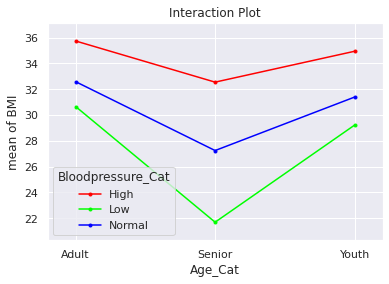

In [65]:
interaction_plot(x=df['Age_Cat'].astype("str"), trace=df['Bloodpressure_Cat'].astype("str"), response=df['BMI'])
plt.title("Interaction Plot")
plt.show()

In [66]:
pt = pg.pairwise_tukey(dv='BloodPressure',between='Age_Cat',effsize='cohen',data=df)
print(pt)

       A       B    mean(A)    mean(B)       diff        se         T  \
0  Youth   Adult  67.318352  74.969262  -7.650910  0.876628 -8.727656   
1  Youth  Senior  67.318352  79.538462 -12.220109  3.270840 -3.736077   
2  Adult  Senior  74.969262  79.538462  -4.569199  3.236270 -1.411872   

    p-tukey     cohen  
0  0.000000 -0.664363  
1  0.000588 -1.061127  
2  0.335232 -0.396764  


In [67]:
pt = pg.pairwise_tukey(dv='SkinThickness',between='Age_Cat',effsize='cohen',data=df)
print(pt)

       A       B    mean(A)    mean(B)      diff        se         T  \
0  Youth   Adult  27.044944  30.254098 -3.209155  0.659923 -4.862926   
1  Youth  Senior  27.044944  28.461538 -1.416595  2.462276 -0.575319   
2  Adult  Senior  30.254098  28.461538  1.792560  2.436252  0.735786   

    p-tukey     cohen  
0  0.000004 -0.370174  
1  0.833339 -0.163403  
2  0.742284  0.206771  


#### Number of Pregnancies, Family factors

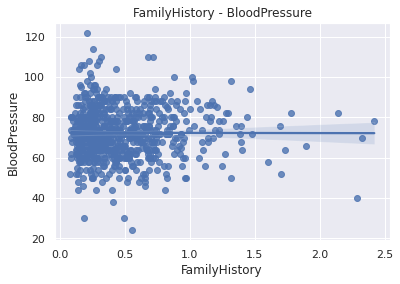

In [68]:
sns.regplot(x="FamilyHistory", y="BloodPressure", data = df)
plt.title("FamilyHistory - BloodPressure")
plt.show()

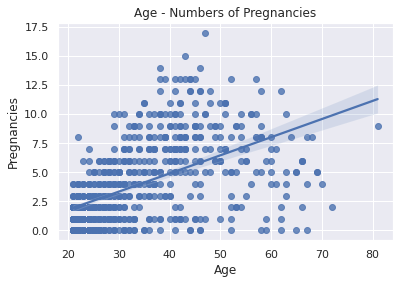

In [69]:
sns.regplot(x="Age", y="Pregnancies", data = df)
plt.title("Age - Numbers of Pregnancies")
plt.show()

### Linear Regression

#### Insulin

In [70]:
# Peforming OLS regression
X = df[num_features].drop(["Insulin"], axis = 1)
y = df["Insulin"]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Insulin   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     22.82
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           2.06e-31
Time:                        06:38:01   Log-Likelihood:                -4430.8
No. Observations:                 768   AIC:                             8880.
Df Residuals:                     759   BIC:                             8921.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.4111     21.793     -0.845      0.398     -61.192      24.370
Pregnancies      -0.4953      1.010     -0.490      0.624      -2.478       1.487
Glucose           1.1745      0.110     10.711      0.000       0.959       1.390
BloodPressure    -0.5262      0.259     -2.033      0.042      -1.034      -0.018
SkinThickness     0.4524      0.385      1.174      0.241      -0.304       1.209
BMI               1.0308      0.523      1.973      0.049       0.005       2.057
FamilyHistory    14.7954      8.733      1.694      0.091      -2.349      31.940
Age               0.1418      0.305      0.465      0.642      -0.456       0.740
Outcome          -6.0871      7.161     -0.850      0.396     -20.144       7.970
==============================================================================
Omnibus:                      515.535   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7222.724
Skew:                           2.865   Prob(JB):                         0.00
Kurtosis:                      16.888   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
# Use sklearn to perform a linear regression model
# And predict values
X = df[num_features].drop(["Insulin"], axis = 1)
features = X.columns
y = df["Insulin"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ -12.049218017849824
-------Coefficients-------
Pregnancies :  {0.03147619696174633}
Glucose :  {1.2680156438126264}
BloodPressure :  {-0.5976913440337407}
SkinThickness :  {0.35206282213330164}
BMI :  {0.8471022334739043}
FamilyHistory :  {19.740336653865484}
Age :  {-0.020060343025746885}
Outcome :  {-9.442357822755676}
--------------------------
MAE: 46.05598105429969
MSE: 4854.81461486478
RMSE: 69.67649973172288


In [72]:
features = ["Glucose", "BMI", "BloodPressure"]
X = df[features]
y = df["Insulin"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ 2.710493451514253
-------Coefficients-------
Glucose :  {1.2245697545318937}
BMI :  {1.1003426628504411}
BloodPressure :  {-0.6278709477033362}
--------------------------
MAE: 45.826573383809915
MSE: 4785.859102455595
RMSE: 69.17990389163312


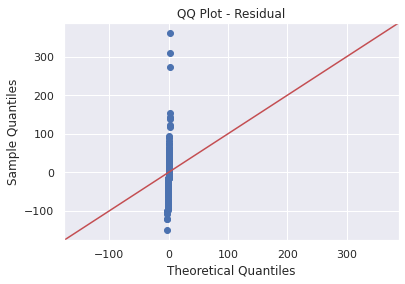

In [73]:
# Print qq plot for residual
res = y_test - y_pred
sm.qqplot(res,line="45")
plt.title("QQ Plot - Residual")
plt.show()

#### BMI

In [74]:
X = df[num_features].drop(["BMI"], axis = 1)
y = df["BMI"]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     60.43
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           3.27e-76
Time:                        06:38:02   Log-Likelihood:                -2380.6
No. Observations:                 768   AIC:                             4779.
Df Residuals:                     759   BIC:                             4821.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7359      1.426      9.633      0.000      10.937      16.535
Pregnancies      -0.0492      0.070     -0.703      0.482      -0.187       0.088
Glucose           0.0021      0.008      0.253      0.800      -0.014       0.018
BloodPressure     0.1181      0.017      6.761      0.000       0.084       0.152
SkinThickness     0.3632      0.023     15.625      0.000       0.318       0.409
Insulin           0.0049      0.003      1.973      0.049    2.39e-05       0.010
FamilyHistory     1.4242      0.604      2.358      0.019       0.238       2.610
Age              -0.0836      0.021     -4.001      0.000      -0.125      -0.043
Outcome           2.7118      0.487      5.574      0.000       1.757       3.667
==============================================================================
Omnibus:                       28.444   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.581
Skew:                           0.329   Prob(JB):                     9.35e-10
Kurtosis:                       3.930   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
X = df[num_features].drop(["BMI"], axis = 1)
features = X.columns
y = df["BMI"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ 12.716975226431135
-------Coefficients-------
Pregnancies :  {-0.07735249400371196}
Glucose :  {0.01212708669556014}
BloodPressure :  {0.1209796350247791}
SkinThickness :  {0.3682302535571486}
Insulin :  {0.003883944225744524}
FamilyHistory :  {1.5152385268338753}
Age :  {-0.09200189205067921}
Outcome :  {2.837533113786471}
--------------------------
MAE: 4.36719548404507
MSE: 28.965343914746327
RMSE: 5.381946108495172


In [76]:
features = ["SkinThickness","BloodPressure","Insulin", "FamilyHistory","Age", "Outcome"]
X = df[features]
y = df["BMI"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ 13.573239163793644
-------Coefficients-------
SkinThickness :  {0.36866499729397156}
BloodPressure :  {0.12425504874838716}
Insulin :  {0.00532910367420808}
FamilyHistory :  {1.5871198024440483}
Age :  {-0.09963856944109921}
Outcome :  {3.078181717203914}
--------------------------
MAE: 4.284904410434608
MSE: 28.18466559086313
RMSE: 5.308923204460876


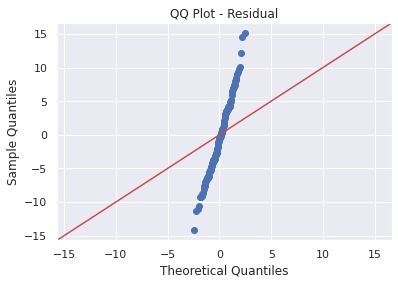

In [77]:
res = y_test - y_pred
sm.qqplot(res,line="45")
plt.title("QQ Plot - Residual")
plt.show()

#### Diabetes Outcome

In [78]:
X = df[num_features].drop(["Outcome"], axis = 1)
y = df["Outcome"]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     44.90
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           4.25e-59
Time:                        06:38:02   Log-Likelihood:                -371.86
No. Observations:                 768   AIC:                             761.7
Df Residuals:                     759   BIC:                             803.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0237      0.104     -9.841      0.000      -1.228      -0.819
Pregnancies       0.0206      0.005      4.074      0.000       0.011       0.031
Glucose           0.0065      0.001     11.967      0.000       0.005       0.008
BloodPressure    -0.0012      0.001     -0.924      0.356      -0.004       0.001
SkinThickness     0.0002      0.002      0.098      0.922      -0.004       0.004
Insulin          -0.0002      0.000     -0.850      0.396      -0.001       0.000
BMI               0.0145      0.003      5.574      0.000       0.009       0.020
FamilyHistory     0.1306      0.044      2.963      0.003       0.044       0.217
Age               0.0021      0.002      1.355      0.176      -0.001       0.005
==============================================================================
Omnibus:                       33.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.901
Skew:                           0.322   Prob(JB):                     6.46e-06
Kurtosis:                       2.424   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
X = df[num_features].drop(["Outcome"], axis = 1)
features = X.columns
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ -0.9654929641174623
-------Coefficients-------
Pregnancies :  {0.016384400408592178}
Glucose :  {0.006646615532440109}
BloodPressure :  {-0.002113940541031474}
SkinThickness :  {-0.0008403678237600794}
Insulin :  {-0.000236884902771968}
BMI :  {0.015526040306868006}
FamilyHistory :  {0.12396336909469416}
Age :  {0.002996017351410009}
--------------------------
MAE: 0.3085349823175392
MSE: 0.13927574678441407
RMSE: 0.37319665966406246


In [80]:
features = ["Pregnancies","Glucose","BMI", "FamilyHistory"]
X = df[features]
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Intercept_", regressor.intercept_)
print("-------Coefficients-------")

for i in range(len(features)):
  print(features[i], ": ", {regressor.coef_[i]})
print("--------------------------")
y_pred = regressor.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Intercept_ -1.013947240392606
-------Coefficients-------
Pregnancies :  {0.020427572160281515}
Glucose :  {0.006514779986161841}
BMI :  {0.013577372219603926}
FamilyHistory :  {0.1268301548408831}
--------------------------
MAE: 0.3030432514068628
MSE: 0.13553199412195346
RMSE: 0.36814670190286025


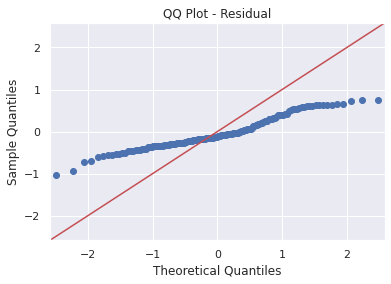

In [81]:
res = y_test - y_pred
sm.qqplot(res,line="45")
plt.title("QQ Plot - Residual")
plt.show()

##### Classification

In [82]:
# Get train and test data and then apply base classifier
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Outcome"],axis = 1), df["Outcome"], test_size=0.3, random_state = 5)

model = DummyClassifier(strategy='most_frequent')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

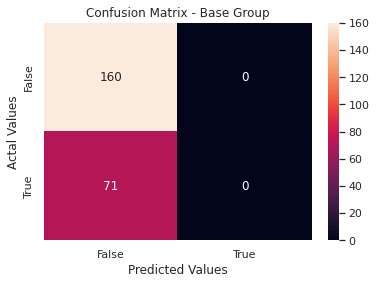

In [83]:
# Print results
result_df = pd.DataFrame(confusion_matrix(y_test, y_pred),index = ["False", "True"], columns=["False", "True"])
sns.heatmap(result_df, annot=True,fmt='d')
plt.title('Confusion Matrix - Base Group')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig("/content/drive/MyDrive/INF2178/Midterm/fig4.jpg")
plt.show()

In [84]:
results = precision_recall_fscore_support(y_test, (y_pred>0.5).astype(int), average="weighted")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {results[0]}")
print(f"Recall: {results[1]}")
print(f"F1: {results[2]}")

Accuracy: 0.6926406926406926
Precision: 0.4797511291017785
Recall: 0.6926406926406926
F1: 0.5668670630307459


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
X = df[num_features].drop(["Outcome"], axis = 1)
features = X.columns
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

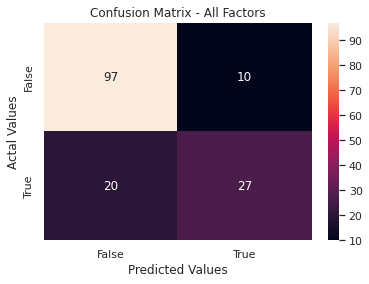

In [86]:
result_df = pd.DataFrame(confusion_matrix(y_test, (y_pred>0.5).astype(int)),index = ["False", "True"], columns=["False", "True"])
sns.heatmap(result_df, annot=True,fmt='d')
plt.title('Confusion Matrix - All Factors')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [87]:
results = precision_recall_fscore_support(y_test, (y_pred>0.5).astype(int), average="weighted")
print(f"Accuracy: {accuracy_score(y_test, (y_pred>0.5).astype(int))}")
print(f"Precision: {results[0]}")
print(f"Recall: {results[1]}")
print(f"F1: {results[2]}")

Accuracy: 0.8051948051948052
Precision: 0.7987447987447989
Recall: 0.8051948051948052
F1: 0.7979475881261596


In [88]:
features = ["Pregnancies","Glucose","BMI", "FamilyHistory"]
X = df[features]
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

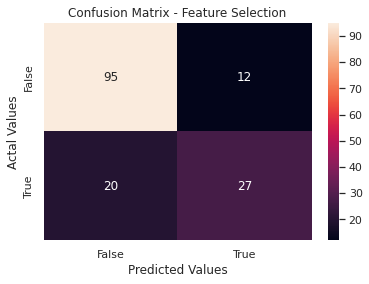

In [89]:
result_df = pd.DataFrame(confusion_matrix(y_test, (y_pred>0.5).astype(int)),index = ["False", "True"], columns=["False", "True"])
sns.heatmap(result_df, annot=True,fmt='d')
plt.title('Confusion Matrix - Feature Selection')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig("/content/drive/MyDrive/INF2178/Midterm/fig5.jpg")
plt.show()

In [90]:
results = precision_recall_fscore_support(y_test, (y_pred>0.5).astype(int), average="weighted")
print(f"Accuracy: {accuracy_score(y_test, (y_pred>0.5).astype(int))}")
print(f"Precision: {results[0]}")
print(f"Recall: {results[1]}")
print(f"F1: {results[2]}")

Accuracy: 0.7922077922077922
Precision: 0.7852582200408288
Recall: 0.7922077922077922
F1: 0.7862870421009955
